In [2]:
using DifferentialEquations, Optim, Plots, DataFrames, LinearAlgebra, CSV, BenchmarkTools

### Data Import

In [3]:
# Steady State Hashimoto
sample_IM = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/DDR_initials.csv"));
patient_list = [7228995, 62352978, 78490026, 1179621568, 1708857679]
sample_IM.t = 12 * sample_IM.t;

In [4]:
function normalize_time(labs_df, dose_df)
    t_0 = min(minimum(labs_df.t), minimum(dose_df.t))
    labs_df.t = (labs_df.t .- t_0).*24
    dose_df.t = (dose_df.t .- t_0).*24
    patient_data = (labs_df, dose_df)
    return patient_data
end

function import_patient(patient_ID)
    data_dir = "C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/Parsed_data/"
    info_path = data_dir * "patient-$patient_ID.txt"
    labs_path = data_dir * "patient-$patient_ID.csv"
    dose_path = data_dir * "patient_meds-$patient_ID.csv"
    labs_df = DataFrame(CSV.File(labs_path))
    dose_df = DataFrame(CSV.File(dose_path))

    patient_data = normalize_time(labs_df, dose_df)
    return patient_data
end

import_patient (generic function with 1 method)

In [5]:
function plot_patient(patient; title::String="Patient Labs")
    labs = patient[1]
    meds = patient[2]

    T4T3Labels = ["FT4 (ng/dL)", "FT3 (pg/dL)"]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]
    xlims = (min(minimum(labs.t)/24, minimum(meds.t)/24), max(maximum(labs.t)/24, maximum(meds.t))/24)

    t = labs.t/24
    
    p1 = plot(t, labs.T4, label="T4", xlim=xlims, ylabel=T4T3Labels[1])
    any(dose_df.Levothyroxine .!= 0) && (p1 = plot!(twinx(), meds.Levothyroxine, xlim=xlims, ylabel="Levothyroxine (mcg/day)", label="Dose", color = "red", xticks=:none))
    p1 = hline!(T4T3Ranges[1], label= "")
    p1 = scatter!(t, labs.T4, alpha = 0.3, label="")
    
    p2 = plot(t, labs.T3, label="", xlim=xlims, ylabel=T4T3Labels[2])
    any(dose_df.Lyothyronine .!= 0) && (p2 = plot!(twinx(), meds.Lyothyronine, xlim=xlims, ylabel="Liothyronine (mcg/day)", label = "Dose", color = "red", xticks=:none))
    p2 = hline!(T4T3Ranges[2], label= "")
    p2 = scatter!(t, labs.T3, alpha = 0.3, label="")
    
    p3 = plot(t, labs.TSH, label="", xlim=xlims, ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t, labs.TSH, alpha = 0.3)

    p4 = plot(t, labs.Lymphocytes, xlim=xlims, ylabel="Lymphocytes (cell/mL)", label="")
    p4 = scatter!(t, labs.Lymphocytes, alpha = 1, label="")

    p5 = plot(t, labs.Ab, ylabel="TPOAb (IU/mL)", xlim=xlims, xlabel="time [days]", label="")
    p5 = scatter!(t, labs.Ab, alpha = 1, label="")

    layout = @layout [a b ; c ; d e]
    plot!(size=(900,900))
    p_main = plot(p1, p2, p3, p4, p5, layout=layout)
    p_main[:plot_title] = title
    plot(p_main)

end

plot_patient (generic function with 1 method)

### Parameter + ODEs

In [80]:
function fixed_parameters()
    p = zeros(Float64, 82)
    dial=[1.0; 0.88; 1.0; 0.88]
    p[1] = 0.0027785399344 #S4
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05
    p[30] = 450            #Bzero
    p[31] = 219.7085301388 #Azero
    p[32] = 0              #Amax
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH
    p[49] = 3.001011022378 #K_circ
    p[50] = 3.094711690204 #K_SR_tsh
    p[51] = 5.674773816316 #n_hillcirc
    p[52] = 6.290803221796 #m_hillTSH
    p[53] = 8.498343729591 #K_f4 for f4
    p[54] = 14.36664496926 #l_hillf3
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 excretion rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 excretion rate
    p[61] = 5.003761571969437   # σT4
    p[62] = 0.11122955089297369 # σT3
    p[63] = 0.4                 # σTSH
    p[64] = 0.1                 # σFT4
    p[65] = 21.82854404275587 # maleBMI_ref
    p[66] = 22.99050845201536 # femaleBMI_ref
    p[67] = 1.0 #Vtsh_scale
    p[69] = 1.0 # PV_ratio
    p[70] = -1.0 # PV
    p[71] = 1.0 # PV_allometric_exp
    p[72] = 1.0 # fat_free
    p[73] = 0.0 # fat
    p[74] = 1.0 # slow_scale
    p[75] = 1.0 # fast_scale
    p[76] = 0.75 # male_allometric
    p[77] = 0.75 # female_allometric
    p[78] = 1.7608716659237555 # male_ref_height
    p[79] = 1.6696106891941103 # female_ref_height
    p[80] = 1.0499391485135692 # male_clearace
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion
    return p
end

function ics()
    ic    = zeros(Float64, 25)
    ic[1] = 1.322114215761171 #T4dot
    ic[2] = 0.201296960359917 #T4fast
    ic[3] = 0.638967411907560 #T4slow
    ic[4] = 0.00663104034826483 #T3pdot
    ic[5] = 0.0112595761822961 #T3fast
    ic[6] = 0.0652960640300348 #T3slow
    ic[7] = 1.78829584764370 #TSHp
    ic[8] = 7.05727560072869 #T3B
    ic[9] = 7.05714474742141 #T3B_lag
    ic[10] = 0 #T4PILLdot
    ic[11] = 0 #T4GUTdot
    ic[12] = 0 #T3PILLdot
    ic[13] = 0 #T3GUTdot
    ic[14] = 3.34289716182018 #delay1
    ic[15] = 3.69277248068433 #delay2
    ic[16] = 3.87942133769244 #delay3
    ic[17] = 3.90061903207543 #delay4
    ic[18] = 3.77875734283571 #delay5
    ic[19] = 3.55364471589659 #delay6
    ic[20] = 100 # B-cells
    ic[21] = 20 # Plasma cells 
    ic[22] = 100 # CD4+ cells
    ic[23] = 5e9 # Cytokines
    ic[24] = 5 # FTS
    ic[25] = 2e9 # Antibodies

    return ic
end

function initialize_free()
    p = zeros(23)
    # Immune Parameters
    p[1] = 3.0e-3 # B-cell activation rate, will probably be lower due to T3 term p[15]
    p[2] = 1.0e-2 # Plasma cell transformation rate
    p[3] = 8.05e-1 # CD4+ activation rate
    p[4] = 51.84e5 # Cytokine production rate
    p[5] = 1.0e6 # relative growth rate of FTS
    p[6] = 1.0e6 # combined antibody production rate
    p[7] = 2.0e-6 # B-cell death rate
    p[8] = 4.0e-2 # Plasma cell death rate
    p[9] = 8.91e-3 # CD4+ cell death rate
    p[10] = 0.189  # Cytokine degredation rate
    p[11] = 1.0e-2 # Functional thyroid destruction rate
    p[12] = 1.74e-3 # Blood Ab degredation rate
    p[13] = 18.0e5 # B-cell cytokine binding activation threshold
    p[14] = 2.0e6 # CD4+ T-cell cytokine binding activation threshold
    p[15] = 1.0e3 # NOTE: NEED TO FIT and CHANGE
    p[16] = 0.0 #1e3 # 98 FT4 T-cell stimulation
    p[17] = 9.1e-4 # 99 CD4+ T-cell stimulation rate
    p[18] = 13.5 # 100 Euthyroid FTS

    # Fitting Variance
    p[19] = 1.0 # 101 T4 Variance
    p[20] = 1.0 # 102 T3 Variance
    p[21] = 1.0 # 103 TSH Variance
    p[22] = 1.0 # 104 Lymphocyte Variance
    p[23] = 1.0 # 105 Antibody Variance

    return p
end

function initialize_all()
    p = zeros(105)
    p[1:82] = fixed_parameters()
    p[83:105] = initialize_free()
    return p
end

initialize_all (generic function with 1 method)

In [88]:
function thyrosimIM!(dq, q, p, t)
    kdelay = 5/8

    # Scaling the mass/concentration of compartments
    plasma_volume_ratio = p[69]^p[71]
    slow_volume_ratio = p[74]^p[71]
    fast_volume_ratio = p[75]^p[71]

    # Scale comparment sizes
    q1 = q[1] * 1 / p[69]
    q2 = q[2] * 1 / p[75]
    q3 = q[3] * 1 / p[74]
    q4 = q[4] * 1 / p[69]
    q5 = q[5] * 1 / p[75]
    q6 = q[6] * 1 / p[74]
    q7 = q[7] * 1 / p[69]

    # Auxillary equations
    q4F = (p[24]+ p[25] * q1 + p[26] * q1^2 + p[27] * q1^3) * q4 #FT3p
    q1F = (p[7] + p[8] * q1 + p[9] * q1^2 + p[10] * q1^3) * q1  #FT4p
    SR3 = (q[24]/p[100])*(p[19] * p[59] * q[19]) # Scaled (q[24]/p[99]) Brain delay (dial 3)
    SR4 = (q[24]/p[100])*(p[1] * p[57] * q[19])  # Scaled (q[24]/p[99]) Brain delay (dial 1)
    fCIRC = q[9]^p[51] / (q[9]^p[51] + p[49]^p[51])
    SRTSH = (p[30]+p[31]*fCIRC*sin(pi/12*t-p[33]))*(p[50]^p[52]/(p[50]^p[52] + q[9]^p[52]))
    fdegTSH = p[34] + p[35] / (p[36] + q7)
    fLAG = p[41] + 2*q[8]^11 / (p[42]^11 + q[8]^11)
    f4 = p[37]*(1 + 5*(p[53]^p[54]) / (p[53]^p[54]+q[8]^p[54]))
    NL = p[13] / (p[14] + q2)

    # Main ODEs
    dq[1]  = p[81] + (SR4 + p[3] * q2 + p[4] * q3 - (p[5] + p[6]) * q1F) * plasma_volume_ratio + p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (p[6] * q1F - (p[3] + p[12] + NL) * q2) * fast_volume_ratio                                    #T4fast
    dq[3]  = (p[5] * q1F -(p[4] + p[15] / (p[16] + q3) + p[17] /(p[18] + q3)) * q3) * slow_volume_ratio  #T4slow
    dq[4]  = p[82] + (SR3 + p[20] * q5 + p[21] * q6 - (p[22] + p[23]) * q4F) * plasma_volume_ratio + p[28] * q[13] #T3pdot
    dq[5]  = (p[23] * q4F + NL * q2 - (p[20] + p[29]) * q5) * fast_volume_ratio                         #T3fast
    dq[6]  = (p[22] * q4F + p[15] * q3 / (p[16] + q3) + p[17] * q3 / (p[18] + q3) -(p[21])*q6) * slow_volume_ratio #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * plasma_volume_ratio                                           #TSHp
    dq[8]  = f4 / p[38] * q1 + p[37] / p[39] * q4 - p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  p[43] * q[10] - (p[44] * p[58]+ p[11]) * q[11]                  #T4GUTdot: note p[44] * p[58] = p[44] * dial[2] = k4excrete
    dq[12] = -p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  p[45] * q[12] - (p[46] * p[60] + p[28]) * q[13]                 #T3GUTdot: note p[46] * p[60] = p[46] * dial[4] = k3excrete

    # Delay ODEs
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2: TSH delay
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])                                         #delay6

    # Immune ODEs
    dq[20] = p[83]*(q[23]/(q[23]+p[96]))*q[22]+(p[98]*q1F)-(p[90]+p[84])*q[20] # Bdot -- changed to T4 stimulation
    dq[21] = p[84]*q[20]-p[91]*q[21] # Pdot
    dq[22] = p[85]*q[24]+p[88]*q1F-p[99]*(q[23]/(q[23]+p[97]))*q[22]-p[92]*q[22] # Tdot
    dq[23] = p[86]*q[22]-p[93]*q[23] # Cdot
    dq[24] = p[87]*((q7/q[24])*p[100])-p[94]*(q[24])*q[25] #p[87]*((q7/q[24])*p[100])-p[93]*(q[24]/p[100])*q[25] # FTSdot MODIFIED
    dq[25] = p[89]*q[21]-q[25]*(p[95]+p[93]*q[24]) # Abdot

    return nothing
end;

In [93]:
function simulate(model, ic, tspan, params; use_callback::Bool = false, free_indices=[], solver = Rosenbrock23(), warmup::Bool=false)
    #find_patient_ic!(ic,combine_params(free_parameters[1:end-9], fixed_parameters, free_indicies=free_indicies), 15)
    # if warmup
    #     find_patient_ic!(ic, combine_params(free_parameters[1:end-5], fixed_parameters, free_indicies=free_indices), 30)
    # end
    if use_callback
        problem = ODEProblem(model, ic,tspan, params)
        sol = solve(problem, solver, callback = dose_callback, tstops = dose_times)
        return sol
    else
        problem = ODEProblem(model, ic, tspan, params)
        sol = solve(problem, solver)
        return sol
    end
end 

#Unit adjustment.. total to free conversion with internal polynomials

function FT4(TT4::Float64)
    return (0.000289 + (0.000214 * TT4) + (0.000128 * TT4^2) - (8.83e-6 * TT4^3)) * 1000 * TT4
end

function FT3(TT3::Float64)
    return 1000*TT3
end

function AbUnits(Ab::Float64)
    Ab*10.0e-8
end

AbUnits (generic function with 1 method)

In [94]:
function simplot(sol; alt_model::Bool = false, automargins::Bool = true, title = "Unit Test 1")
    
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = FT4.(sol[1, :])
    T3 = FT3.(sol[4, :])
    T4T3Labels = ["FT4 (ng/dL)", "FT3 (pg/dL)"]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]
    TSH = 5.6 * sol[7, :] / p[48]
    Bcell = sol[20, :]
    Pcell = sol[21, :]
    Tcell = sol[22, :]
    Lymphocytes = sol[20, :].+sol[21, :] .+ sol[22, :]
    TPOAb = AbUnits.(sol[25, :]) # convert to pM from molecules/mL
    alt_model && (TPOAb = AbUnits.(sol[24, :])) # convert to pM from molecules/mL
    alt_model && (TGAb = AbUnits.(sol[25, :]))

    xlim=(0,sol.t[end]/24) 
    if automargins
        t4lim = max(1.2*maximum(T4), T4T3Ranges[1][2]*1.1)
        t3lim = max(1.2*maximum(T3), T4T3Ranges[2][2]*1.1)
        tshlim = max(1.2maximum(TSH), 5.5)
        Llim = 1.2maximum(Lymphocytes)
        TPOlim = 1.2maximum(TPOAb)
        alt_model && (TGlim = 1.2maximum(TGAb))
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), xlim=xlim, label="", ylabel=T4T3Labels[1])
    p1 = hline!(T4T3Ranges[1], label= "")
    #p1 = scatter!(data.t./24, data.T4, alpha = 0.3, label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), xlim=xlim, label="", ylabel=T4T3Labels[2])
    p2 = hline!(T4T3Ranges[2], label= "")
    #p2 = scatter!(data.t./24, data.T3, alpha = 0.3, label= "")
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), xlim=xlim, label="", ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")
    #p3 = scatter!(data.t./24, data.TSH, alpha = 0.3, label= "")

    p4 = plot(sol.t / 24.0, Lymphocytes, ylabel="Lymphocytes (cell/mL)", ylim=(0,Llim), xlim=xlim, label="")
    #p4 = scatter!(data.t./24, data.Lymphocytes, alpha = 0.3, label= "")
    p4 = plot!(sol.t /24.0, Bcell, label = "B-Cells")
    p4 = plot!(sol.t /24.0, Tcell, label = "T-Cells")
    p4 = plot!(sol.t /24.0, Pcell, label = "Plasma Cells")

    p5 = plot(sol.t / 24.0, TPOAb, ylabel="TPOAb (IU/mL)", xlabel="time [days]", ylim=(0,TPOlim), xlim=xlim, label="")
    #p5 = scatter!(data.t./24, data.Ab, alpha = 0.3, label= "")
    
    if alt_model
        p6 = plot(sol.t / 24.0, TGAb, ylabel="TGAb (IU/mL)", xlabel="time [days]", ylim=(0,TGlim), xlim=xlim, label="")
        l = @layout [a b ; c ; d e f]
        plot!(size=(900,900))
        p_main = plot!(p1, p2, p3, p4, p5, p6, layout=l)
    else
        # p6 = plot(dose_df.t / 24.0, dose_df.Levothyroxine, ylabel="Oral Levothyroxine (mcg/day)", xlabel = "time [days]", label="")
        l = @layout [a b ; c ; d e]
        plot!(size=(900,900))
        p_main = plot!(p1, p2, p3, p4, p5, layout=l)
    end
    

    p_main[:plot_title] = title
    plot(p_main)
end;

### Unit Tests

In [99]:
# Unfit simulation... check for inf, bounds erros
params = initialize_all()
initial_conditions = ics()
tspan = (0,720)
utest1 = simulate(OGthyrosimIM!, initial_conditions, tspan, params);

┌ Warning: dt(1.1368683772161603e-13) <= dtmin(1.1368683772161603e-13) at t=1.4957570902812691, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:599


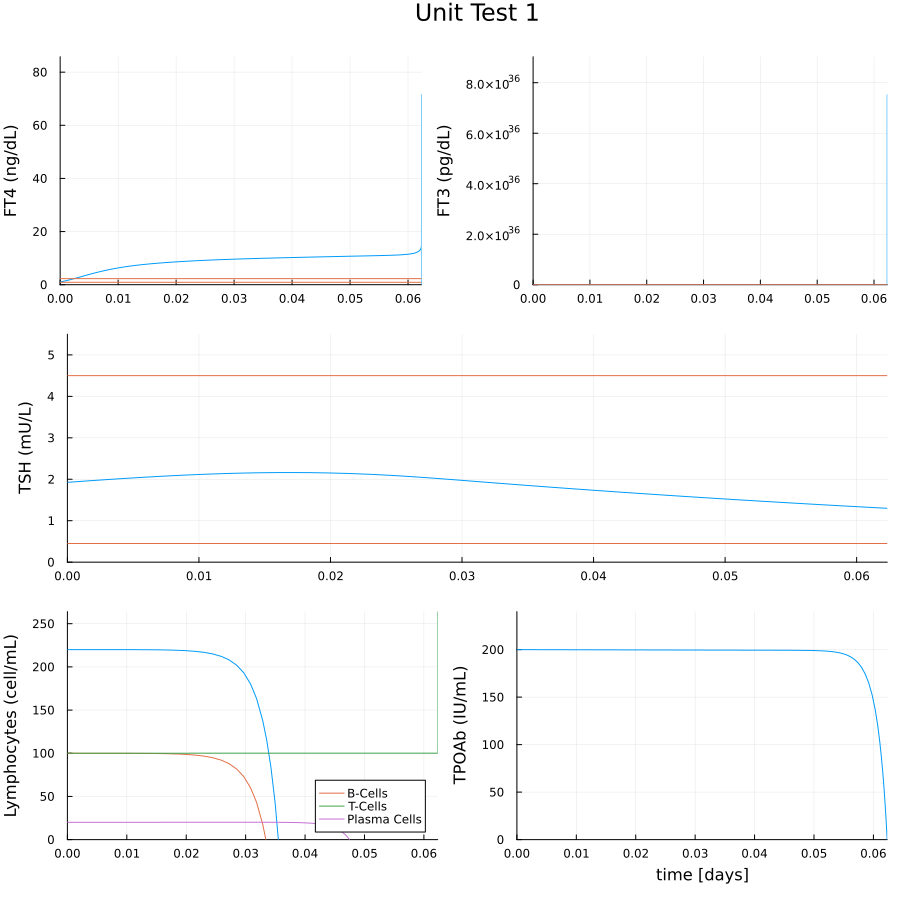

In [100]:
simplot(utest1)

In [108]:
import NaNMath # handles log of negative number that can occur due to adaptive ODE solvers


function combine_params(free_parameters::Vector, fixed_parameters::Vector; free_indicies::Vector=[])
    if isempty(free_indicies) #assume fixed... + free... is correctly ordered parameter Vector
        p = [fixed_parameters; free_parameters] 
    else # we must have free_parameters in same order as free_indicies. fixed_parameters must be in ascending index order
        p = zeros(size(free_parameters, 1) + size(fixed_parameters, 1))
        fixed_indicies = setdiff(1:size(p, 1), free_indicies)
        for i in eachindex(p)
            if i in(free_indicies)
                p[i] = free_parameters[findall(x -> x == i, free_indicies)[1]] 
            else   
                p[i] = fixed_parameters[findall(x -> x == i, fixed_indicies)[1]] 
            end
        end
    end
    return p
end

function lsq_loss(sol, time, data, _)
    data_columns = names(data)[2:6] # this selects T4,T3, TSH, Lymphocytes, Ab
    sol_indicies = [[1],[4],[7],[20,21,22],[25]] # indicies for T4, T3, TSH, Lymphocytes, Ab
    loss_vector = [0.0,0.0,0.0,0.0,0.0] # loss for T4,T3, TSH, Lymphocytes, Ab respectivley
    for (i, column) in enumerate(data_columns)
        if any(!ismissing, data[!, column])
            column_mean = mean(skipmissing(data[!, column]))
            for (j, t) in enumerate(time)
                datapoint = data[!, column][j]
                if ismissing(datapoint)
                    loss_vector[i] = loss_vector[i]
                else
                    predicted = 0
                    if column == "FT4"
                        predicted = FT4(sol(t)[sol_indicies[i]])
                        loss_vector[i]+= ((predicted - datapoint)/column_mean)^2
                    elseif column == "FT3"
                        predicted = FT3(sol(t)[sol_indicies[i]])
                        loss_vector[i]+= ((predicted - datapoint)/column_mean)^2
                    elseif column == "Ab"
                        predicted = TPOConvert(sol(t)[sol_indicies[i]])
                        loss_vector[i]+= ((predicted - datapoint)/column_mean)^2
                    else
                        for state_variable in sol_indicies[i]
                            predicted += sol(t)[state_variable]
                        end
                        loss_vector[i] += ((predicted - datapoint)/column_mean)^2
                    end
                end
            end
        else
            loss_vector[i] += 0
        end
    end

    global GLOBAL_LOSS
    GLOBAL_LOSS = vcat(GLOBAL_LOSS, loss_vector')
    
    return loss_vector
end

function objective(
    free_parameters::Vector,
    fixed_parameters::Vector,
    ics::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    model=thyrosimIM!,
    loss_function::Function=neg_logl,
    solver=Rosenbrock23(),
    use_callback::Bool = false)

    # Bound solution space - needs to be replaced with Optim native options
    for (i, parameter) in enumerate(free_parameters[1:end-5])
        if !(lb[i] ≤ parameter ≤ ub[i])
            # println("Parameter $i with value $parameter was out of bounds $(lb[i]) -- $(ub[i]).")
            return 10e6
        end
    end

    variances = free_parameters[end-4:end]

    # assign t from data, initialize thyrosim problem and compute solution
    t = data.t; tspan = (t[1], t[end])

    sol = simulate(model, ics, tspan, free_parameters, fixed_parameters, warmup = false, use_callback = use_callback)

    # For now, we are fitting 6 state variables (1,4,7, 20:22). Thus, last 6 parameters must be
    # corresponding variance of the state variables for MLE, can make variable SV number in future
    loss = loss_function(sol, t, data, variances)
    
    total_loss = sum(loss)

    return total_loss
end

"""
**Required Args**
 - `params`: A vector containing all parameters used in the ODE Model
 - `free_index`: A vector of integer values specifying the indices of free parameters to be fit by the optimization routine. One parameter for each state variable variance **MUST** be provided at the end of the parameter list.
 - `ics`: Initial state variable values
 - `lb` and `ub`: Vectors with lower and upper bounds for free parameters (must be same length)
 - `data`: Dataframe with patient lab values

 ### _Note_: a Dataframe named dose_df with patient LT4 dosing MUST be defined or the function will throw an error
 
 **Keyword Args**
 - `model`: defaults to `thyrosimIM!`. Can provide alternate model here
 - `loss_function`: How loss is calculated from data (WLS, MLE, custom function....)
 - `use_callback`: specify true if patient has medication values. These must be provided as a dataframe named `dose_df`
 - `optimization_routine`: Nelder-Mead(), Newton(), LBFGS(), etc.. See [Optim.jl Documentation](https://docs.sciml.ai/Optimization/stable/optimization_packages/optim/) for available search routines
 - `iterations`: maximum iterations to run for. Defaults to 100k iterations
 - `time_limit`: maximum time (in seconds) to run parameter search. Note this applies only to optim and does not account for time taken to actually solve ODE problem and calculate loss. Usually takes about double the time you enter here to complete the search if maximum iterations is not reached
 """
function fit_all(
    params::Vector,
    free_index::Vector{Int},
    ics::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    model=thyrosimIM!,
    loss_function::Function=lsq_loss,
    use_callback::Bool = false,
    optimization_routine = NelderMead(),
    iterations::Int = 100000,
    time_limit::Number = 200.0)

    # set fixed parameter indexing and split params vector into free and fixed
    fixed_index = Int.(setdiff(collect(1:length(params)), free_index))
    free_params_initial = params[free_index]
    fixed_params = params[fixed_index]

    # print("Free Parameters: $(params[free_index]). Fixed Parameters: $(params[fixed_index])")

    print("Fitting...")
    solution = optimize(free_params -> objective(free_params, fixed_params, ics, lb, ub, data, 
        model=model, loss_function=loss_function, use_callback=use_callback),
        free_params_initial, optimization_routine, 
        Optim.Options(time_limit = time_limit, iterations = iterations, g_tol=1e-10,
        show_trace = false, allow_f_increases=true))
    return solution
end

fit_all

In [109]:
fit_all(params, Int.(collect(83:length(params))), initial_conditions, zeros(5), 10.0e4.*initial_conditions, sample_IM)

Fitting...

 * Status: success

 * Candidate solution
    Final objective value:     1.000000e+07

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-10

 * Work counters
    Seconds run:   0  (vs limit 200)
    Iterations:    0
    f(x) calls:    25
